# Age Prediction from Pixel Dataset (Facial Images)

## Outline

Importing Relevant Libraries and Modules

    Import necessary Python libraries and modules.
    Set random seeds for reproducibility.
    Load the dataset 'age_gender.csv'.

Exploratory Data Analysis

    Transform pixel values into a usable format.
    Check for missing values, non-numeric characters, and invalid pixel lengths.
    Visualize sample grayscale images from the dataset.

Data Preprocessing

    Define age ranges and create a function to map ages to class labels.
    Map age classes to the respective images in the dataset.
    Analyze the distribution of age ranges in the dataset.
    
Data Splitting

    Split the dataset into training, validation, and test sets.

Data Augmentation

    Apply data augmentation techniques to the images for training.

Model Architecture

    Create a Convolutional Neural Network (CNN) model using Keras.
    Specify the model's architecture, including convolutional layers, pooling layers, batch normalization, dropout, and dense layers.
    Compile the model with an adaptive learning rate scheduler.

Training the Model

    Train the CNN model using the training dataset.
    Utilize data augmentation during training.
    Monitor training progress with validation data.

Model Evaluation

    Evaluate the trained model on a separate test dataset.
    Calculate and display classification metrics, including accuracy and loss.

In [1]:
# pip install scikeras

In [2]:
# pip install imbalanced-learn

## Importing relevant Python libraries and modules

In [3]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize as sk_resize
import scikeras.wrappers as skwrappers

import tensorflow as tf
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from keras.models import Model
from keras import layers, models, utils
from keras.layers import Dense, Flatten, Activation, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_columns', None)             #To display al columns

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
np.random.seed(42)
tf.random.set_seed(42)

Using TensorFlow backend


# Load the dataset

In [10]:
data = pd.read_csv('age_gender.csv')
data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


## Exploratory Data Analysis

In [11]:
X = np.array(data['pixels'].tolist())

In [12]:
print(X.shape)

(23705,)


In [13]:
"""
Convert the pixel values to NumPy arrays of integers
"""
# Where our 'pixels' column contains space-separated pixel values as strings
X = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int))

# Stack the arrays to create a 3D NumPy array
X = np.stack(X.values)

# Reshape the array to (number of samples, height, width, number of channels)
X = X.reshape(X.shape[0], 48, 48, 1)

# Now, X should have the desired shape for further processing
print(X.shape)

(23705, 48, 48, 1)


In [14]:
# Check the length of each pixel value in the 'pixels' column
pixel_lengths = data['pixels'].apply(lambda x: len(x.split()))  # Assuming pixel values are space-separated

# Print unique lengths (there should be only one unique length if all are valid)
unique_lengths = pixel_lengths.unique()
print(unique_lengths)

[2304]


In [15]:
# Check for missing or NaN values in the 'pixels' column
missing_values = data['pixels'].isnull().sum()

if missing_values == 0:
    print("There are no missing or NaN values in the 'pixels' column.")
else:
    print(f"There are {missing_values} missing or NaN values in the 'pixels' column.")

There are no missing or NaN values in the 'pixels' column.


In [16]:
non_numeric_chars = data['pixels'].apply(lambda x: ''.join(filter(lambda char: not char.isdigit() and char != ' ', x)))
unique_non_numeric_chars = non_numeric_chars.unique()
print("Unique non-numeric characters:", unique_non_numeric_chars)

Unique non-numeric characters: ['']


In [17]:
invalid_lengths = data['pixels'].apply(lambda x: len(x.split())) != 2304
invalid_length_rows = data[invalid_lengths]
print("Rows with invalid pixel lengths:", len(invalid_length_rows))

Rows with invalid pixel lengths: 0


### Visualizing some Sample Images

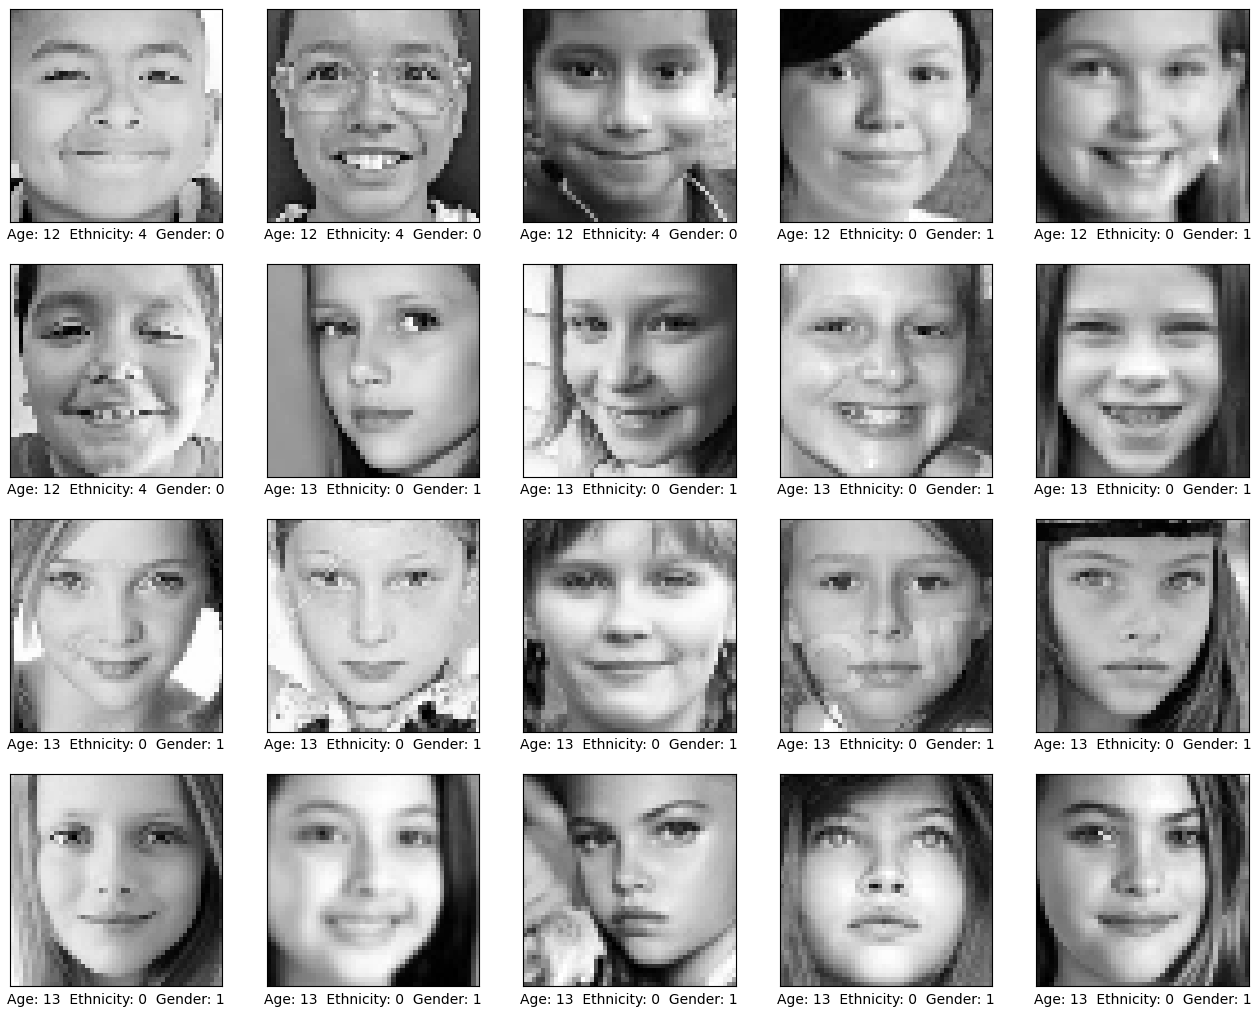

In [18]:
plt.figure(figsize=(16, 16))
for i in range(1500, 1520):
    plt.subplot(5, 5, (i % 20) + 1)  # Changed from 25 to 20 to match the loop range
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i].reshape(48, 48), cmap='gray')  # Use 'X' for reshaped data
    plt.xlabel(
        "Age: " + str(data['age'].iloc[i]) +
        "  Ethnicity: " + str(data['ethnicity'].iloc[i]) +
        "  Gender: " + str(data['gender'].iloc[i])
    )

plt.show()

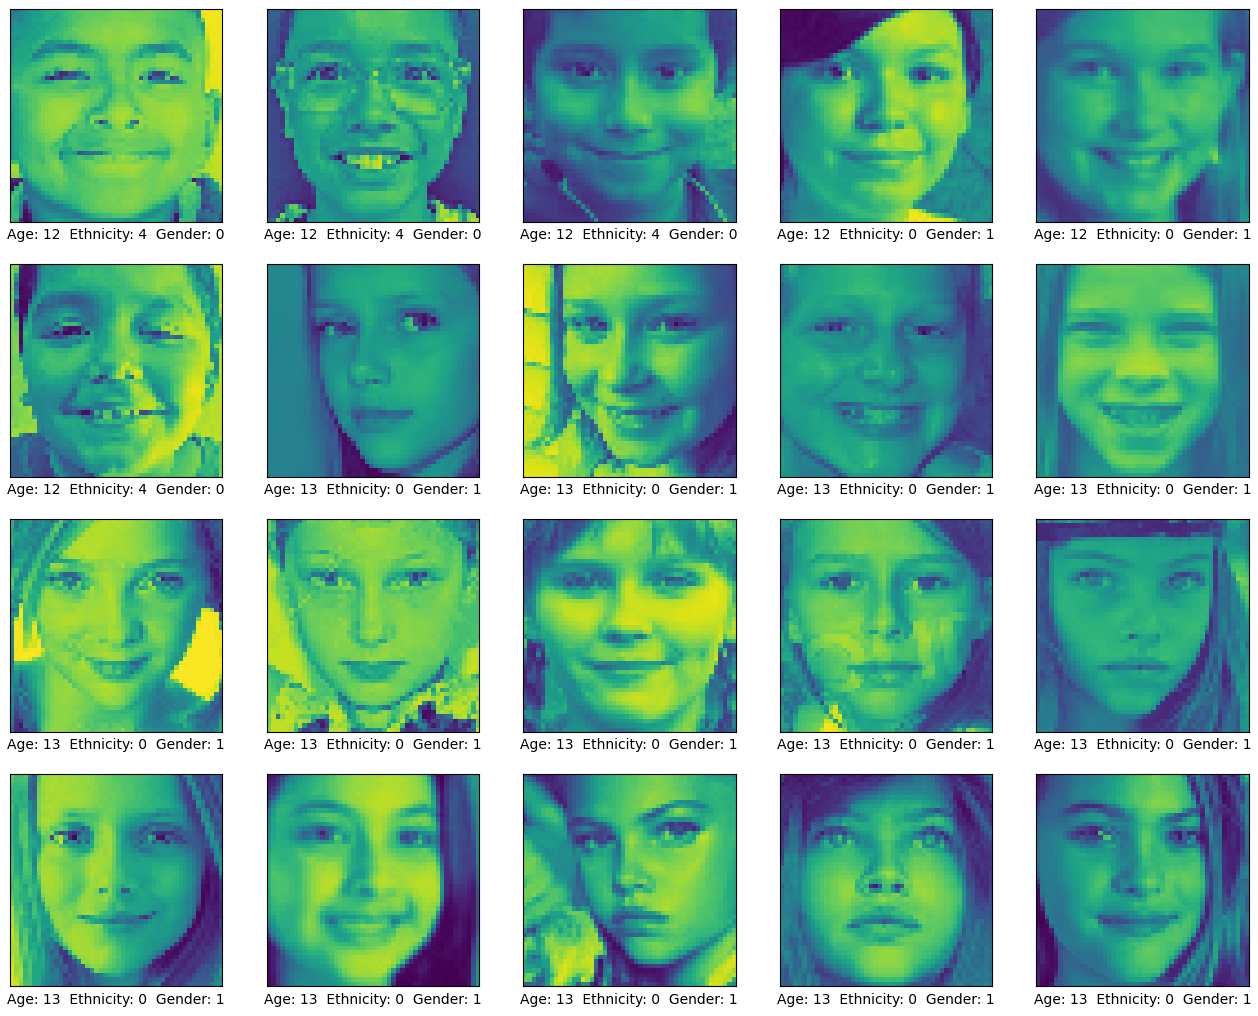

In [19]:
# Where 'X' contains grayscale images with shape (number of samples, height, width, 1)
# Apply a colormap to the grayscale images for visualization
X_color = plt.cm.viridis(X.squeeze())  # You can choose a different colormap

plt.figure(figsize=(16, 16))
for i in range(1500, 1520):
    plt.subplot(5, 5, (i % 20) + 1)  # Changed from 25 to 20 to match the loop range
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_color[i])
    plt.xlabel(
        "Age: " + str(data['age'].iloc[i]) +
        "  Ethnicity: " + str(data['ethnicity'].iloc[i]) +
        "  Gender: " + str(data['gender'].iloc[i])
    )

plt.show()

## Data Preprocessing

### Defining age ranges
We define a function map_age_to_class that takes an age as input and maps it to a specific class label. This is done to convert an age prediction task, which is originally a regression task (predicting a continuous value), into a classification task (predicting a discrete class label). The function defines age ranges and assigns a class label based on which range the input age falls into. This discretization of ages allows for treating the problem as a classification problem, making it more suitable for certain machine learning algorithms and evaluation metrics.

In [20]:
"""
Defining a function`map_age_to_class`
"""
def map_age_to_class(age):
    if age >= 1 and age <= 2:
        return 0
    elif age >= 3 and age <= 9:
        return 1
    elif age >= 10 and age <= 20:
        return 2
    elif age >= 21 and age <= 27:
        return 3
    elif age >= 28 and age <= 45:
        return 4
    elif age >= 46 and age <= 65:
        return 5
    else:
        return 6  # You can define a default class for ages outside the specified ranges

### Mapping the new age class to the respective images/age
We assign class labels to the 'target' column in a DataFrame 'data' based on the ages in the 'age' column. It uses the previously defined map_age_to_class function to map ages to specific class labels. 

In [21]:
data['target'] = data['age'].map(map_age_to_class)

In [16]:
data

,age,ethnicity,gender,img_name,pixels,target
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,0
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,0
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,0
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,0
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,0
...,...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,6
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,6
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,6
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,6


### Distribution of our age ranges

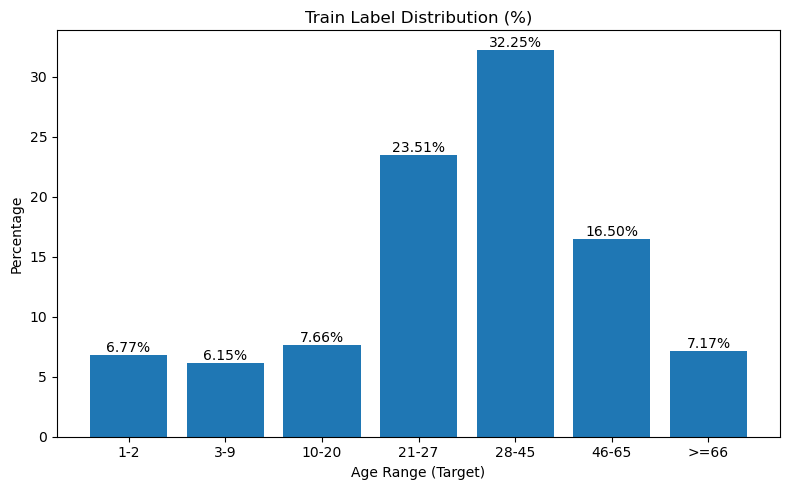

In [17]:
# Define the class ranges and labels
class_ranges = [
    "1-2",
    "3-9",
    "10-20",
    "21-27",
    "28-45",
    "46-65",
    ">=66"
]

# Get the label distribution for each set
train_label_distribution = data['target'].value_counts(normalize=True).sort_index() * 100

# Create bar plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Function to add percentage labels on top of bars
def add_percentage_labels(ax, distribution):
    for i, percentage in enumerate(distribution):
        ax.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

# Train set
train_bars = ax.bar(class_ranges, train_label_distribution)
ax.set_title("Train Label Distribution (%)")
ax.set_xlabel("Age Range (Target)")
ax.set_ylabel("Percentage")
add_percentage_labels(ax, train_label_distribution)

plt.tight_layout()
plt.show()

### Data Splitting
We split the data into training and testing sets. It assigns the 'target' column as the target variable 'y' and the features as 'X'. The 'train_test_split' function is used to create two subsets for training ('X_train' and 'y_train') and testing ('X_test' and 'y_test') machine learning models. This is a common step in preparing data for model training and evaluation.

In [18]:
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Modeling

### Label Encoding
The code converts integer class labels into one-hot encoded format, where each class label is represented as a binary vector. This transformation is commonly used in multi-class classification tasks. 'y_train_encoded' and 'y_test_encoded' now contain one-hot encoded representations of the target labels.

In [19]:
# Convert your integer class labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=7)  # Assuming you have 7 classes
y_test_encoded = to_categorical(y_test, num_classes=7)  # Assuming you have 7 classes

## TensorBoard Callback 
Creating and saving a TensorBoard callback is necessary since we intend to use TensorBoard, which is a powerful visualization tool provided by TensorFlow. TensorBoard allows us to monitor and visualize various aspects of our model's training and performance.

In [4]:
# Specify the directory where you want to save TensorBoard logs
log_dir = "tensorboard"

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)  # Adjust the frequency as needed

### ModelCheckpoint Callback

Creating a ModelCheckpoint callback is necessary to save the model's weights during training, based on certain criteria, such as the validation accuracy.

In [5]:
# Specify the directory where you want to save model checkpoints
checkpoint_dir = "modelCheckpoint"

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_weights.h5"),
    monitor="val_accuracy",  # You can use other metrics like "val_loss" if needed
    save_best_only=True,     # Save only the best model based on the monitored metric
    save_weights_only=False,  # Save the complete model whenever the validation accuracy improves
    verbose=1                # Display messages when a checkpoint is saved
)

## CNN Architectural - Original

The code defines a Convolutional Neural Network (CNN) using Keras for image classification. Here's a brief breakdown:

    1. Sequential Model: A linear stack of layers, allowing one layer at a time.

    2. Input Layer: Expects 48x48-pixel grayscale images.

    3. Convolutional Layers: Extract features from input images.
        Three sets of Convolutional + Batch Normalization + Max-Pooling layers.
        ReLU activation is used in the convolutional layers.

    4. Flatten Layer: Converts the output into a 1D vector for fully connected layers.

    5. Fully Connected Layers: Responsible for classification.
        A dense layer with 64 units and ReLU activation.
        Dropout with a rate of 50% is applied to prevent overfitting.

    6. Output Layer: Seven units for multi-class classification using softmax activation.

    Compile the Model: Configuration for training.
        Adam optimizer.
        Categorical cross-entropy loss for multi-class problems.
        Accuracy as the evaluation metric.

    Summary: Provides an overview of the model's architecture, layer details, and parameter counts.

In [22]:
# Create a Sequential model
model = models.Sequential()

# Input layer with the appropriate input shape (48, 48, 1)
model.add(layers.InputLayer(input_shape=(48, 48, 1)))

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(layers.Flatten())

# Fully connected layers for classification
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate=0.5))

# Output layer for classification with 7 classes and 'softmax' activation
model.add(layers.Dense(7, activation='softmax'))

# Compile the model for classification
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for classification
              metrics=['accuracy'])

# Summary of the updated model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                        

In [23]:
# Fit the model to your training data with validation data
history = model.fit(
    X_train, y_train_encoded, 
    epochs=20, 
    validation_split=0.1, 
    batch_size=64, 
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/20
267/267 [==============================] - ETA: 0s - loss: 1.6014 - accuracy: 0.3513
Epoch 1: val_accuracy improved from -inf to 0.43279, saving model to modelCheckpoint\model_weights.h5
267/267 [==============================] - 33s 119ms/step - loss: 1.6014 - accuracy: 0.3513 - val_loss: 1.3348 - val_accuracy: 0.4328
Epoch 2/20
267/267 [==============================] - ETA: 0s - loss: 1.2989 - accuracy: 0.4417
Epoch 2: val_accuracy improved from 0.43279 to 0.49288, saving model to modelCheckpoint\model_weights.h5
267/267 [==============================] - 31s 114ms/step - loss: 1.2989 - accuracy: 0.4417 - val_loss: 1.1762 - val_accuracy: 0.4929
Epoch 3/20
267/267 [==============================] - ETA: 0s - loss: 1.2150 - accuracy: 0.4700
Epoch 3: val_accuracy did not improve from 0.49288
267/267 [==============================] - 30s 111ms/step - loss: 1.2150 - accuracy: 0.4700 - val_loss: 1.3939 - val_accuracy: 0.3716
Epoch 4/20
267/267 [==============================] 

### Visualizing the Loss and Accuracy of the Train and Val Sets

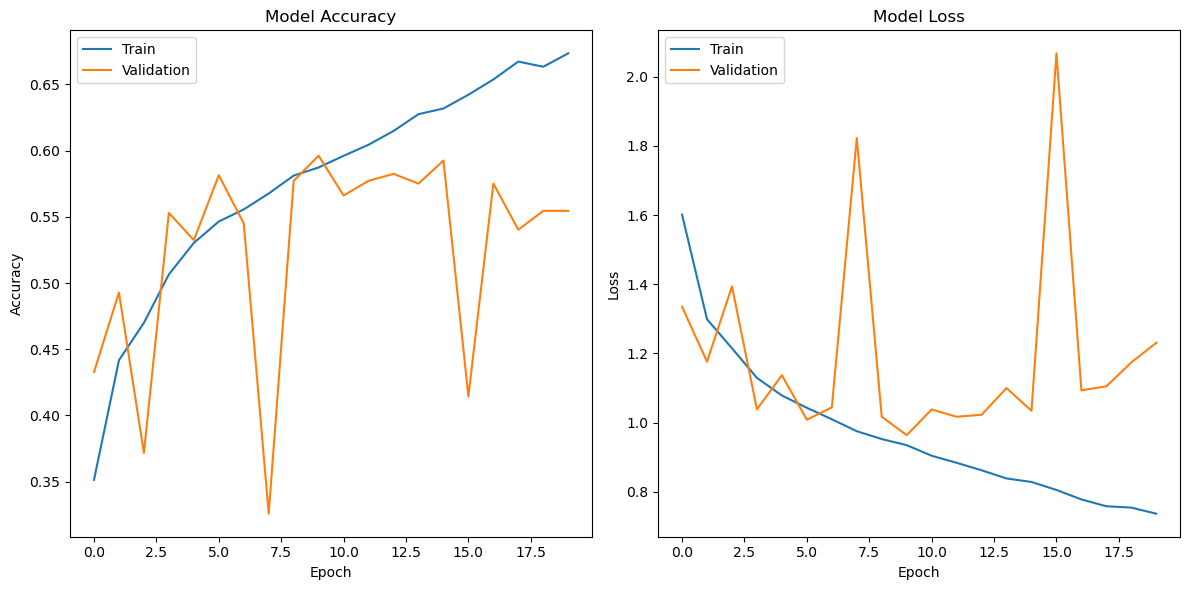

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## CNN Architectural - Custom

The code also defines a custom Convolutional Neural Network (CNN) architecture for image classification using Keras.With some modification compared to the former:

    Sequential Model: A linear stack of layers.

    Input Layer: Accepts 48x48-pixel grayscale images.

    Convolutional Layers: Extract features from input images.
        The first layer has 32 filters with a 3x3 kernel and ReLU activation.
        Each successive Conv2D layer doubles the number of filters.
        After each Conv2D layer, there is an AveragePooling2D layer for downsampling.

    GlobalAveragePooling2D Layer: Averages feature maps spatially, reducing the output to the same number of channels as the last Conv2D layer (256 in this case).

    Dense Layers:
        One Dense layer with 132 units and ReLU activation for feature reduction.
        The output layer with 7 units for multi-class classification using softmax activation.

    Compile the Model: Configuration for training.
        Adam optimizer with a learning rate of 0.001.
        Categorical cross-entropy loss for multi-class problems.
        Accuracy is used as the evaluation metric.

    Summary: Provides an overview of the model's architecture, including layer details and parameter counts.

In [25]:
custom_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
custom_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1)))    # 3rd dim = 1 for grayscale images.
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
custom_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

custom_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

custom_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in the last Conv2D layer above (256).
custom_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from the no. of outputs of GlobalAveragePooling2D layer above towards the no. of nodes in the output layer below (7).
custom_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
custom_cnn.add(Dense(7, activation='softmax'))

custom_cnn.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',  # Use the correct loss function
                   metrics=['accuracy'])

custom_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 23, 23, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 10, 10, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 4, 4, 128)        

In [26]:
history = custom_cnn.fit(X_train, y_train_encoded,  # Use y_train_encoded instead of y_train
                         validation_split=0.1,  # Replace with your validation data
                         epochs=10,  # Specify the number of training epochs
                         batch_size=32,   # Specify the batch size
                         shuffle=True,
                         callbacks=[tensorboard_callback, checkpoint_callback])  

# Evaluate the model on the test dataset
test_results = model.evaluate(X_test, y_test_encoded)

# Unpack the results into loss and accuracy
test_loss, test_accuracy = test_results[0], test_results[1]  # Use index 1 for accuracy

# Print the test loss and accuracy
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/10
534/534 [==============================] - ETA: 0s - loss: 1.5861 - accuracy: 0.3731
Epoch 1: val_accuracy did not improve from 0.59620
534/534 [==============================] - 30s 54ms/step - loss: 1.5861 - accuracy: 0.3731 - val_loss: 1.3487 - val_accuracy: 0.4270
Epoch 2/10
534/534 [==============================] - ETA: 0s - loss: 1.2354 - accuracy: 0.4774
Epoch 2: val_accuracy did not improve from 0.59620
534/534 [==============================] - 29s 54ms/step - loss: 1.2354 - accuracy: 0.4774 - val_loss: 1.1802 - val_accuracy: 0.4997
Epoch 3/10
534/534 [==============================] - ETA: 0s - loss: 1.1260 - accuracy: 0.5164
Epoch 3: val_accuracy did not improve from 0.59620
534/534 [==============================] - 27s 50ms/step - loss: 1.1260 - accuracy: 0.5164 - val_loss: 1.1185 - val_accuracy: 0.5071
Epoch 4/10
533/534 [============================>.] - ETA: 0s - loss: 1.0546 - accuracy: 0.5464
Epoch 4: val_accuracy did not improve from 0.59620
534/534 [====

### Visualizing the Loss and Accuracy of the Train and Val Sets

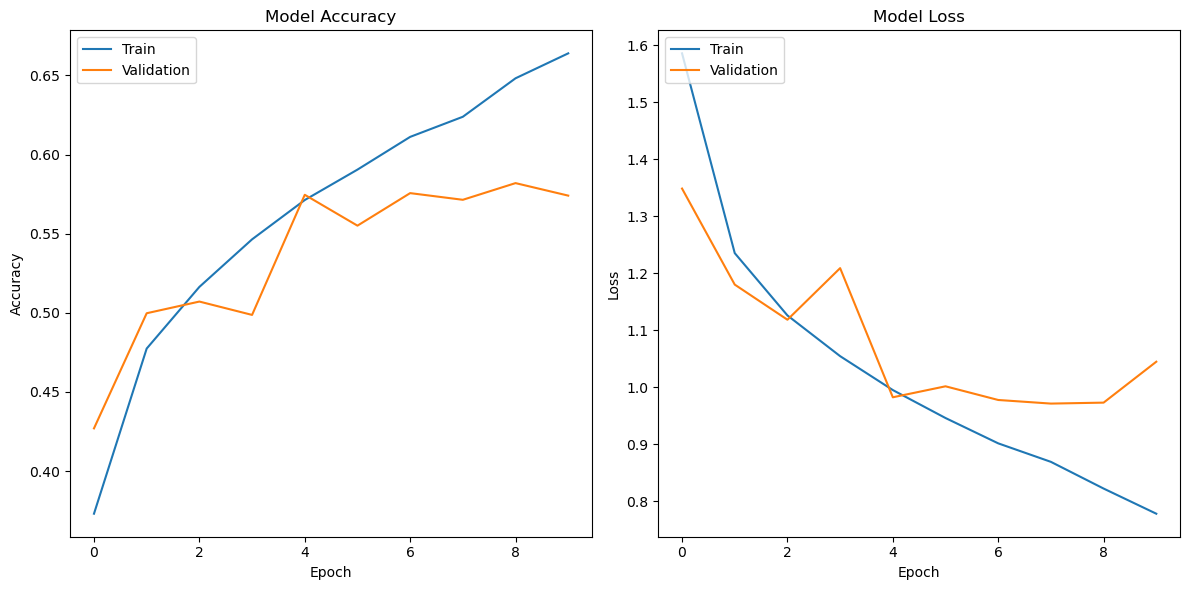

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### The two provided architectures above have some key differences:

    Layer Sequence:
        Original Architecture:
            Begins with a standard input layer.
            Uses Conv2D + BatchNormalization + MaxPooling2D for feature extraction.
            Includes additional fully connected layers before the output layer.
        Custom Architecture:
            Starts with a Conv2D layer directly.
            Employs a series of Conv2D layers with AveragePooling2D for downsampling.
            Utilizes GlobalAveragePooling2D instead of flattening before the dense layers.

    Number of Filters:
        Original Architecture:
            Uses 32, 64, 128, and 256 filters progressively in Conv2D layers.
        Custom Architecture:
            Also uses 32, 64, 128, and 256 filters progressively in Conv2D layers.

    Pooling:
        Original Architecture:
            Applies MaxPooling2D after each Conv2D layer.
        Custom Architecture:
            Uses AveragePooling2D after each Conv2D layer.

    GlobalAveragePooling2D:
        Original Architecture:
            Does not use GlobalAveragePooling2D.
        Custom Architecture:
            Incorporates GlobalAveragePooling2D before the first dense layer.

    Dense Layers:
        Original Architecture:
            Employs two dense layers with dropout between them.
        Custom Architecture:
            Uses one dense layer with a different number of units (132 units) before the output layer.

    Output Layer:
        Both architectures end with an output layer with 7 units for multi-class classification.

    Batch Normalization:
        Original Architecture:
            Includes BatchNormalization layers after Conv2D layers.
        Custom Architecture:
            Does not use BatchNormalization layers.

    Learning Rate:
        Original Architecture:
            Uses the default learning rate for the Adam optimizer.
        Custom Architecture:
            Specifies a learning rate of 0.001 for the Adam optimizer.

# APPROACH 2
We look to augument our training data and strife for possible model improvements

In [28]:
# Load the dataset
df = pd.read_csv('age_gender.csv')

To separate the values in the 5th column ('pixels') into separate columns, you we follow these steps using Pandas:

    1. Split the values in the 'pixels' column using a delimiter (space in this case).
    2. Create new DataFrame columns for each pixel value.

In [29]:
# Split the 'pixels' column by space delimiter and convert to DataFrame
pixels_df = df['pixels'].str.split(' ', expand=True)

# Rename the new columns
num_pixels = len(pixels_df.columns)
new_column_names = [f'pixel_{i}' for i in range(num_pixels)]
pixels_df.columns = new_column_names

# Concatenate the pixel columns with the original DataFrame
df = pd.concat([df, pixels_df], axis=1)

# Drop the original 'pixels' column if no longer needed
df.drop('pixels', axis=1, inplace=True)

### Converting string objects to numeric data types
The pixel columns (pixel_0, pixel_1, ..., pixel_2303) are of type object, which means they are currently stored as strings. To perform any numerical computations or machine learning tasks, we must convert these pixel columns to numeric data types, typically int or float. We achieve this conversion using the pd.to_numeric function.

In [ ]:
# # We create a list of column names that start with 'pixel_', which represents all the pixel columns in your DataFrame.
# pixel_columns = df.columns[df.columns.str.startswith('pixel_')]

# # We use df[pixel_columns] to select only the pixel columns.
# # We apply the pd.to_numeric function to convert the selected columns to numeric data types.
# df[pixel_columns] = df[pixel_columns].apply(pd.to_numeric)

### Splitting our dataframe before augmentation

In [31]:
# Split the DataFrame into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the temp DataFrame into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

Shape of Train_df: (16593, 2308), Shape of Val_df: (3556, 2308), Shape of Test_df: (3556, 2308)


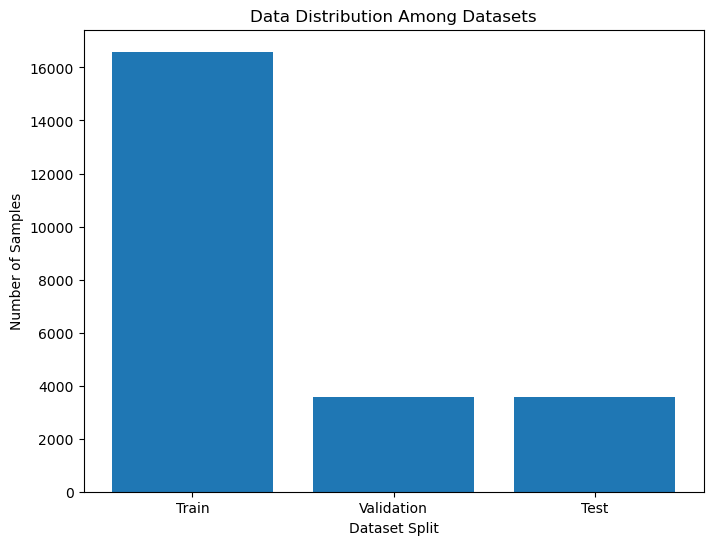

In [32]:
print(f'Shape of Train_df: {train_df.shape}, Shape of Val_df: {val_df.shape}, Shape of Test_df: {test_df.shape}')

# Calculate the lengths of each DataFrame
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

# Create a bar plot to show the distribution
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation', 'Test'], [train_size, val_size, test_size])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Data Distribution Among Datasets')
plt.show()

## Data Augmentation

The code augments image data in a DataFrame by creating multiple variations of each image using random transformations. It then combines the original and augmented data into a new DataFrame. This is typically done to generate more training data for machine learning models.

The code defines a function augment_dataframe to apply data augmentation to a DataFrame of images. Here's a breakdown of the code:

    Function Purpose: The function's purpose is to augment image data by creating multiple variations of each image in the input DataFrame.

    Input Parameters:
        df: The input DataFrame containing image data and metadata.
        num_samples_per_image: The number of augmented versions to create for each image (default is 10).

    Data Augmentation Process:
        The function iterates through each row of the input DataFrame.
        For each row, it extracts the image's pixel data and metadata (age, ethnicity, gender).
        It uses the imgaug library to define an augmentation sequence, which includes horizontal flipping, random rotation, Gaussian blur, Gaussian noise, and brightness adjustment.
        The augmentation sequence is applied to the image, creating a new augmented version.
        Metadata for the augmented image is updated, including a new image name.
        The pixel values of the augmented image are flattened and added as columns to the augmented DataFrame.

    Combining DataFrames:
        After processing all rows, the function combines the original DataFrame with the augmented data into a new DataFrame (augmented_df).
        The concat function is used to stack the DataFrames vertically, and ignore_index=True reindexes the combined DataFrame.

    Runtime Measurement:
        The function records the start time, performs the augmentation, calculates the runtime in minutes, and prints it.

In [33]:
# # Function to apply augmentation and return augmented DataFrame
# def augment_dataframe(df, num_samples_per_image=10):
#     augmented_data = []

#     for _, row in df.iterrows():
#         img_name = row['img_name']
#         pixel_columns = [f'pixel_{i}' for i in range(2304)]
#         pixels = row[pixel_columns].values.reshape(48, 48)  # Assuming images are 48x48 pixels

#         original_image = Image.fromarray(pixels.astype('uint8'))

#         for i in range(num_samples_per_image):
#             # Clone the original image
#             augmented_image = original_image.copy()

#             # Define the augmentation sequence
#             seq = iaa.Sequential([
#                 iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
#                 iaa.Affine(rotate=(-20, 20), mode='reflect'),  # Random rotation between -20 and 20 degrees
#                 iaa.GaussianBlur(sigma=(0, 1.0)),  # Gaussian blur with random sigma
#                 iaa.AdditiveGaussianNoise(scale=(0, 0.1 * 255)),  # Gaussian noise with random scale
#                 iaa.Multiply((0.7, 1.3)),  # Brightness adjustment
#             ])

#             # Apply the augmentation sequence to the image
#             augmented_pixels = seq.augment_image(np.array(augmented_image))

#             # Append augmented image data to the DataFrame
#             augmented_row = {
#                 'age': row['age'],
#                 'ethnicity': row['ethnicity'],
#                 'gender': row['gender'],
#                 'img_name': img_name + f'_augmented{i}',
#             }
#             augmented_row.update({'pixel_' + str(i): val for i, val in enumerate(augmented_pixels.flatten())})
#             augmented_data.append(augmented_row)

#     # Combine original DataFrame and augmented data into a new DataFrame
#     augmented_df = pd.DataFrame(augmented_data)
#     combined_df = pd.concat([df, augmented_df], ignore_index=True)

#     return combined_df

# # Augment the train_df DataFrame
# start_time = time.time()
# train_df_augmented = augment_dataframe(train_df, num_samples_per_image=10)

# end_time = time.time()
# runtime = (end_time - start_time)/60
# print(f'Total runtime is: {runtime} mins')

In [34]:
# train_df_augmented.to_csv('train_df_augmented_v2.csv')
# val_df.to_csv('val_df_v2.csv')
# test_df.to_csv('test_df_v2.csv')

In [6]:
train_df_augmented = pd.read_csv('train_df_augmented_v2.csv')
val_df = pd.read_csv('val_df_v2.csv')
test_df = pd.read_csv('test_df_v2.csv')

# Loading my oversampled dataset
train_df_oversampled = pd.read_csv('train_df_oversampled.csv')

In [22]:
"""
Applying the map_age_to_class function
"""
train_df_augmented['target'] = train_df_augmented['age'].map(map_age_to_class)
val_df['target'] = val_df['age'].map(map_age_to_class)
test_df['target'] = test_df['age'].map(map_age_to_class)

train_df_oversampled['target'] = train_df_oversampled['age'].map(map_age_to_class)

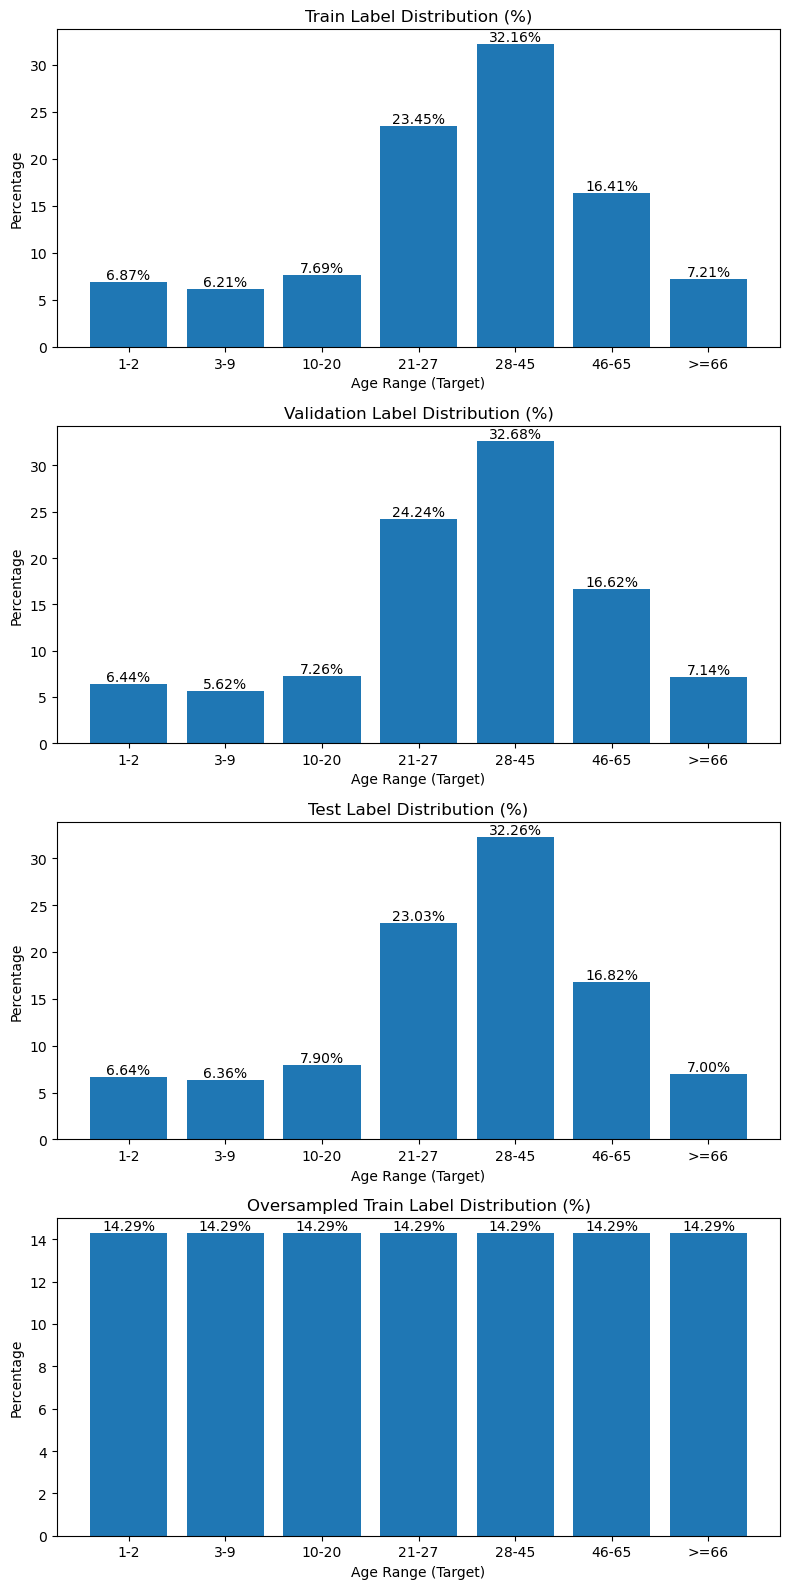

In [23]:
"""
Visualizing the distribution
"""

# Define the class ranges and labels
class_ranges = [
    "1-2",
    "3-9",
    "10-20",
    "21-27",
    "28-45",
    "46-65",
    ">=66"
]

# Get the label distribution for each set
train_label_distribution = train_df_augmented['target'].value_counts(normalize=True).sort_index() * 100
val_label_distribution = val_df['target'].value_counts(normalize=True).sort_index() * 100
test_label_distribution = test_df['target'].value_counts(normalize=True).sort_index() * 100

oversampled_label_distribution = train_df_oversampled['target'].value_counts(normalize=True).sort_index() * 100

# Create bar plots
fig, axes = plt.subplots(4, 1, figsize=(8, 16))

# Function to add percentage labels on top of bars
def add_percentage_labels(ax, distribution):
    for i, percentage in enumerate(distribution):
        ax.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

# Train set
train_bars = axes[0].bar(class_ranges, train_label_distribution)
axes[0].set_title("Train Label Distribution (%)")
axes[0].set_xlabel("Age Range (Target)")
axes[0].set_ylabel("Percentage")
add_percentage_labels(axes[0], train_label_distribution)

# Validation set
val_bars = axes[1].bar(class_ranges, val_label_distribution)
axes[1].set_title("Validation Label Distribution (%)")
axes[1].set_xlabel("Age Range (Target)")
axes[1].set_ylabel("Percentage")
add_percentage_labels(axes[1], val_label_distribution)

# Test set
test_bars = axes[2].bar(class_ranges, test_label_distribution)
axes[2].set_title("Test Label Distribution (%)")
axes[2].set_xlabel("Age Range (Target)")
axes[2].set_ylabel("Percentage")
add_percentage_labels(axes[2], test_label_distribution)

# Oversampled Train set
Oversampled_bars = axes[3].bar(class_ranges, oversampled_label_distribution)
axes[3].set_title("Oversampled Train Label Distribution (%)")
axes[3].set_xlabel("Age Range (Target)")
axes[3].set_ylabel("Percentage")
add_percentage_labels(axes[3], oversampled_label_distribution)

plt.tight_layout()
plt.show()

### Explore the Age Distribution in Our Various Datasets

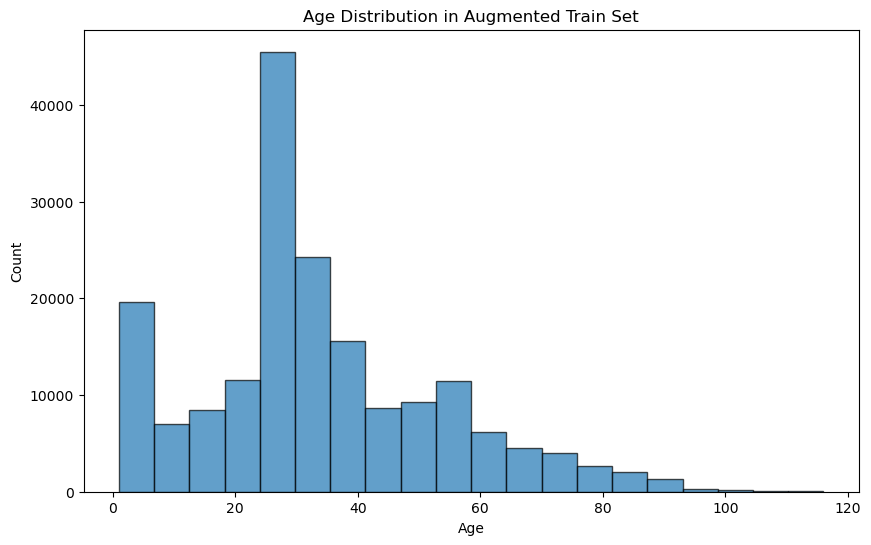

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(train_df_augmented['age'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution in Augmented Train Set')
plt.show()

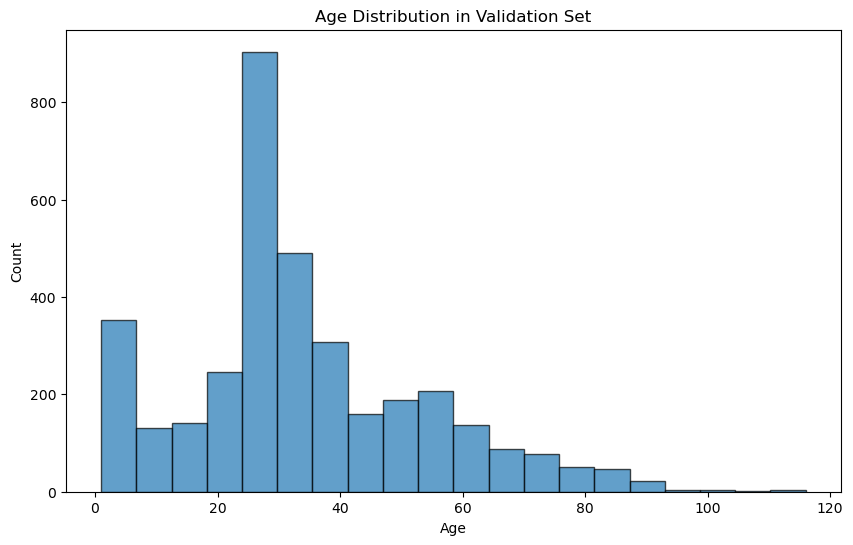

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(val_df['age'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution in Validation Set')
plt.show()

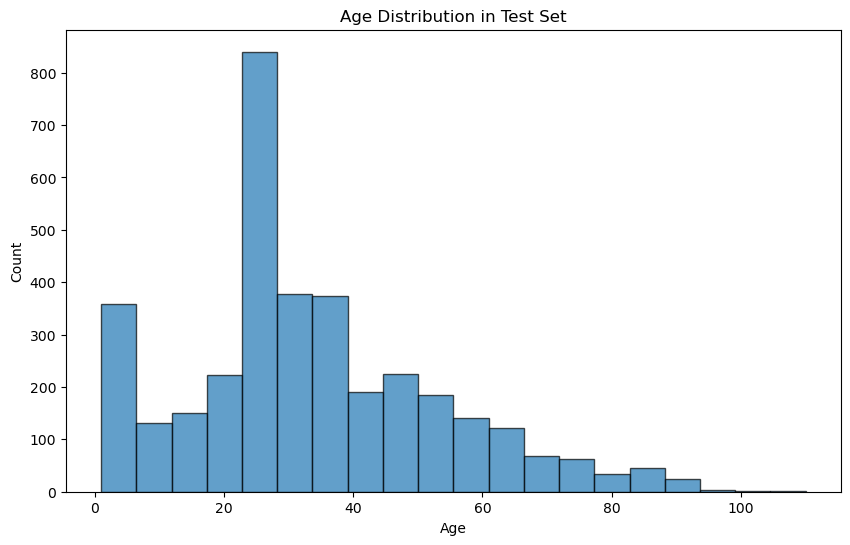

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(test_df['age'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution in Test Set')
plt.show()

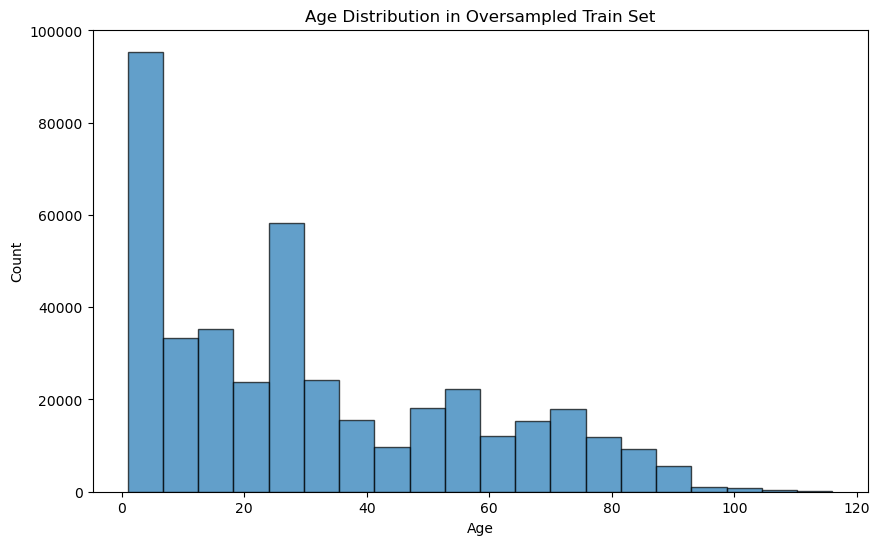

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(train_df_oversampled['age'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution in Oversampled Train Set')
plt.show()

Shape of Train_df_augmented: (182523, 2309), Shape of Val_df: (3556, 2309), Shape of Test_df: (3556, 2309), Shape of Train_df_oversampled: (410872, 2309)


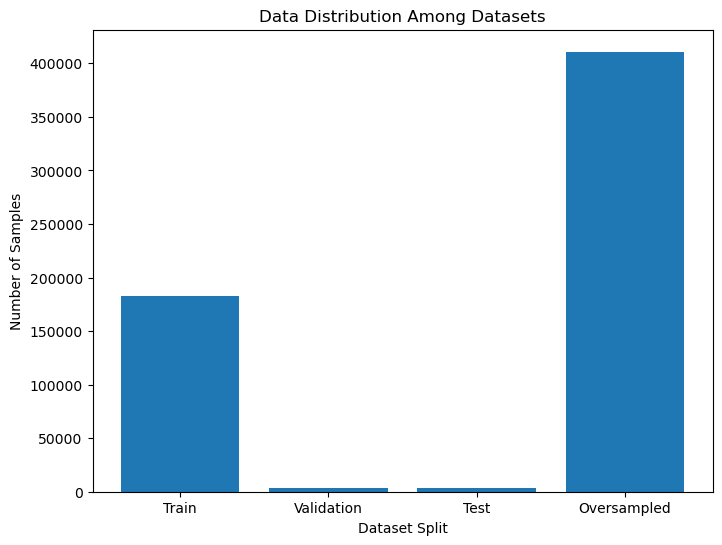

In [29]:
print(f'Shape of Train_df_augmented: {train_df_augmented.shape}, Shape of Val_df: {val_df.shape}, Shape of Test_df: {test_df.shape}, Shape of Train_df_oversampled: {train_df_oversampled.shape}')

# Calculate the lengths of each DataFrame
train_size = len(train_df_augmented)
val_size = len(val_df)
test_size = len(test_df)

oversampled_size = len(train_df_oversampled)

# Create a bar plot to show the distribution
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation', 'Test', 'Oversampled'], [train_size, val_size, test_size, oversampled_size])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Data Distribution Among Datasets')
plt.show()

## Model
Preparing My Dataset for Training and Testing my Convolutional Neural Network.¶

In [30]:
"""
The code extracts pixel data from DataFrames (train_df_augmented, val_df, and test_df) 
and converts it into NumPy arrays for use in machine learning tasks.
"""

train_aug_pixel_data = np.array(train_df_augmented.iloc[:, 4:-1])
val_pixel_data = np.array(val_df.iloc[:, 4:-1])
test_pixel_data = np.array(test_df.iloc[:, 4:-1])

train_oversampled_pixel_data = np.array(train_df_oversampled.iloc[:, 4:-1])

In [31]:
"""
The code defines a function parse_dataframe for processing image data and labels:

    It casts the pixel data to float32 and reshapes it into a 2D image format (48x48 in this case).
    It normalizes the pixel values to the range [0, 1] assuming the original values are in the range [0, 255].
    It converts the label into one-hot encoding format using tf.one_hot.
    The function returns the processed image and its corresponding one-hot encoded label.
"""

num_classes = 7

def parse_dataframe(pixel_data, label):
    # Cast pixel data to float32 and reshape it to 2D (adjust the dimensions as needed)
    image = tf.cast(pixel_data, tf.float32)
    image = tf.reshape(image, [48, 48, 1])  # Replace 'height' and 'width' with the desired dimensions

    # Normalize the pixel values to the range [0, 1]
    image = image / 255.0  # Assuming the pixel values are in the range [0, 255]

    # Convert label to one-hot encoding
    label = tf.one_hot(label, num_classes)

    return image, label

In [32]:
"""
The code prepares TensorFlow Datasets for training, validation, and testing by converting processed image data and labels 
into a suitable format. Each dataset is created from corresponding data and labels, 
and the elements are preprocessed using a function. Finally, the datasets are batched for use in machine learning tasks.
"""

# Create TensorFlow Datasets from my augmented train data
train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_pixel_data, train_df_augmented['target']))
train_aug_dataset = train_aug_dataset.map(lambda pixel_data, label: parse_dataframe(pixel_data, label))
train_aug_dataset = train_aug_dataset.batch(512)  # Adjust batch size as needed

# Create TensorFlow Datasets from my val data
val_df_dataset = tf.data.Dataset.from_tensor_slices((val_pixel_data, val_df['target']))
val_df_dataset = val_df_dataset.map(lambda pixel_data, label: parse_dataframe(pixel_data, label))
val_df_dataset = val_df_dataset.batch(512)  # Adjust batch size as needed

# Create TensorFlow Datasets from my test data
test_df_dataset = tf.data.Dataset.from_tensor_slices((test_pixel_data, test_df['target']))
test_df_dataset = test_df_dataset.map(lambda pixel_data, label: parse_dataframe(pixel_data, label))
test_df_dataset = test_df_dataset.batch(512)  # Adjust batch size as needed

# Create TensorFlow Datasets from my oversampled train data
train_oversampled_dataset = tf.data.Dataset.from_tensor_slices((train_oversampled_pixel_data, train_df_oversampled['target']))
train_oversampled_dataset = train_oversampled_dataset.map(lambda pixel_data, label: parse_dataframe(pixel_data, label))
train_oversampled_dataset = train_oversampled_dataset.batch(512)  # Adjust batch size as needed

## CNN Architectural

Similar to the custom model defiend earlier, but with different dataset <b>(augmented)</b> as input

In [33]:
# Clear any previous TensorFlow sessions and variables
tf.keras.backend.clear_session()

In [22]:
custom_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
custom_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1), padding='same'))    # 3rd dim = 1 for grayscale images.
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
custom_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

custom_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

custom_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in the last Conv2D layer above (256).
custom_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from the no. of outputs of GlobalAveragePooling2D layer above towards the no. of nodes in the output layer below (7).
custom_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
custom_cnn.add(Dense(7, activation='softmax'))

custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 24, 24, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 12, 12, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 6, 6, 128)         0

In [23]:
# Compiling the above created CNN architecture.
custom_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Specify the directory where you want to save TensorBoard logs
log_dir = 'log_dir'

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)  # Adjust the frequency as needed

In [35]:
# Specify the directory where you want to save model checkpoints
checkpoint_dir = 'model_checkpoint.h5'

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_weights.h5"),
    monitor="val_accuracy",  # You can use other metrics like "val_loss" if needed
    save_best_only=True,     # Save only the best model based on the monitored metric
    save_weights_only=False,  # Save the complete model whenever the validation accuracy improves
    verbose=1                # Display messages when a checkpoint is saved
)

In [26]:
# Define the batch size number of epochs for training
batch_size, epochs = 128, 60

# Fitting compiled CNN model.
custom_cnn_history = custom_cnn.fit(
    train_aug_dataset,
    batch_size=batch_size,
    validation_data=val_df_dataset,
    epochs=epochs,
    # class_weight=class_weight_dict,
    callbacks=[tensorboard_callback, checkpoint_callback],
    shuffle=False  # Shuffle the training data
)

# Evaluate the model on the test data
test_loss, test_accuracy = custom_cnn.evaluate(test_df_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/60


2023-09-25 10:23:43.422659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-09-25 10:23:46.439360: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f63e4021b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 10:23:46.439400: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-25 10:23:46.547190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-25 10:23:47.028596: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 [==============================] - ETA: 0s - loss: 1.7057 - accuracy: 0.3205
Epoch 1: val_accuracy improved from -inf to 0.34196, saving model to model_checkpoint.h5/model_weights.h5
357/357 [==============================] - 23s 35ms/step - loss: 1.7057 - accuracy: 0.3205 - val_loss: 1.6290 - val_accuracy: 0.3420
Epoch 2/60
355/357 [============================>.] - ETA: 0s - loss: 1.6367 - accuracy: 0.3480
Epoch 2: val_accuracy improved from 0.34196 to 0.36952, saving model to model_checkpoint.h5/model_weights.h5
357/357 [==============================] - 11s 32ms/step - loss: 1.6368 - accuracy: 0.3478 - val_loss: 1.5766 - val_accuracy: 0.3695
Epoch 3/60
355/357 [============================>.] - ETA: 0s - loss: 1.5692 - accuracy: 0.3718
Epoch 3: val_accuracy improved from 0.36952 to 0.40551, saving model to model_checkpoint.h5/model_weights.h5
357/357 [==============================] - 12s 32ms/step - loss: 1.5691 - accuracy: 0.3718 - val_loss: 1.4700 - val_accuracy: 0.4055


### Improving Model Complexity:
We try increasing the depth of our network. Increase the number of nodes in the Dense layer.

Here, we introduce amongst others:
1. Learning Rate Scheduling:

    The code defines a learning rate schedule that adapts the learning rate during training. It decreases the learning rate after certain epochs, which can help the model converge effectively.

2. Callbacks:

    It uses callbacks like EarlyStopping, ModelCheckpoint, and LearningRateScheduler to control the training process effectively. These callbacks enhance training efficiency and prevent overfitting.

3. Dynamic Hyperparameters:

    It allows dynamic adjustments to the learning rate and other hyperparameters based on the number of training epochs.

In [27]:
custom_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
custom_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1), padding='same'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

# Add more Conv2D layers with increasing filters and fewer pooling layers
custom_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
custom_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

custom_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
custom_cnn.add(AveragePooling2D(pool_size=(2, 2)))

# GlobalAveragePooling2D layer before going into Dense layers
custom_cnn.add(GlobalAveragePooling2D())

# Increase the number of nodes in the Dense layer
custom_cnn.add(Dense(256, activation='relu'))

# Output layer with 7 nodes (equal to the number of classes)
custom_cnn.add(Dense(7, activation='softmax'))

custom_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 average_pooling2d_4 (Avera  (None, 24, 24, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 average_pooling2d_5 (Avera  (None, 12, 12, 128)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 256)      

In [28]:
# Compiling the above created CNN architecture.
custom_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# Define the batch size, number of epochs for training, and the learning rate.
batch_size, epochs = 128, 60
initial_learning_rate = 0.001

# Define a learning rate schedule to decrease the learning rate over epochs.
def lr_schedule(epoch):
    lr = initial_learning_rate
    if epoch >= 30:
        lr *= 0.1
    if epoch >= 45:
        lr *= 0.1
    return lr

# Create callbacks, including early stopping, model checkpointing, and a learning rate scheduler.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile and fit the model.
custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

custom_cnn_history = custom_cnn.fit(
    train_aug_dataset,
    batch_size=batch_size,
    validation_data=val_df_dataset,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    shuffle=True  # Shuffle the training data
)

# Evaluate the model on the test data.
test_loss, test_accuracy = custom_cnn.evaluate(test_df_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/60
357/357 [==============================] - 27s 66ms/step - loss: 1.6950 - accuracy: 0.3209 - val_loss: 1.6244 - val_accuracy: 0.3456 - lr: 0.0010
Epoch 2/60
357/357 [==============================] - 22s 62ms/step - loss: 1.6356 - accuracy: 0.3480 - val_loss: 1.5895 - val_accuracy: 0.3591 - lr: 0.0010
Epoch 3/60
357/357 [==============================] - 22s 62ms/step - loss: 1.5883 - accuracy: 0.3642 - val_loss: 1.4988 - val_accuracy: 0.3937 - lr: 0.0010
Epoch 4/60
357/357 [==============================] - 22s 62ms/step - loss: 1.4909 - accuracy: 0.3955 - val_loss: 1.3767 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 5/60
357/357 [==============================] - 22s 62ms/step - loss: 1.4013 - accuracy: 0.4254 - val_loss: 1.3057 - val_accuracy: 0.4544 - lr: 0.0010
Epoch 6/60
357/357 [==============================] - 22s 62ms/step - loss: 1.3478 - accuracy: 0.4441 - val_loss: 1.2680 - val_accuracy: 0.4618 - lr: 0.0010
Epoch 7/60
357/357 [==============================] - 22s 

### Different Architecture V1:

This code demonstrates a straightforward CNN architecture for image classification, including feature extraction, fully connected layers, and dropout for regularization. It is trained and evaluated for classification accuracy.

In [36]:
# Define the dimensions of your grayscale images (48x48)
image_height, image_width, num_channels = 48, 48, 1  # Set num_channels to 1 for grayscale

# Define the number of output classes (adjust as needed)
num_classes = 7

# Extract pixel data and labels from your dataframes
train_aug_pixel_data = np.array(train_df_augmented.iloc[:, 4:-1])
val_pixel_data = np.array(val_df.iloc[:, 4:-1])
test_pixel_data = np.array(test_df.iloc[:, 4:-1])
train_oversampled_pixel_data = np.array(train_df_oversampled.iloc[:, 4:-1])


y_train = np.array(train_df_augmented['target'])
y_val = np.array(val_df['target'])
y_test = np.array(test_df['target'])
y_oversampled = np.array(train_df_oversampled['target'])

# Normalize the pixel data to the range [0, 1] (assuming they are in the range [0, 255])
train_aug_pixel_data = train_aug_pixel_data / 255.0
val_pixel_data = val_pixel_data / 255.0
test_pixel_data = test_pixel_data / 255.0
train_oversampled_pixel_data = train_oversampled_pixel_data/255.0

In [30]:
# Create a simple CNN model for grayscale images
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
epochs = 15  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

history = model.fit(
    train_aug_pixel_data.reshape(-1, image_height, image_width, num_channels), 
    to_categorical(y_train, num_classes=num_classes),
    validation_data=(val_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                    to_categorical(y_val, num_classes=num_classes)),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                                          to_categorical(y_test, num_classes=num_classes))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/15
5704/5704 [==============================] - 19s 3ms/step - loss: 1.2161 - accuracy: 0.4919 - val_loss: 1.0243 - val_accuracy: 0.5689
Epoch 2/15
5704/5704 [==============================] - 17s 3ms/step - loss: 1.0718 - accuracy: 0.5410 - val_loss: 0.9550 - val_accuracy: 0.5872
Epoch 3/15
5704/5704 [==============================] - 17s 3ms/step - loss: 1.0159 - accuracy: 0.5635 - val_loss: 0.9421 - val_accuracy: 0.5934
Epoch 4/15
5704/5704 [==============================] - 17s 3ms/step - loss: 0.9739 - accuracy: 0.5802 - val_loss: 0.9423 - val_accuracy: 0.5996
Epoch 5/15
5704/5704 [==============================] - 17s 3ms/step - loss: 0.9417 - accuracy: 0.5946 - val_loss: 0.9437 - val_accuracy: 0.6004
Epoch 6/15
5704/5704 [==============================] - 17s 3ms/step - loss: 0.9112 - accuracy: 0.6056 - val_loss: 0.9652 - val_accuracy: 0.6038
Epoch 7/15
5704/5704 [==============================] - 17s 3ms/step - loss: 0.8856 - accuracy: 0.6154 - val_loss: 0.9735 - val_ac

### Doing some more augumentation to finetune

This code performs data augmentation and trains a modified Convolutional Neural Network (CNN) model for image classification. Here's a summary of the key steps:

    Data Augmentation:
        Data augmentation is performed using ImageDataGenerator. Various transformations are applied to the training images, including rotation, width and height shifts, shear, zoom, horizontal flip, and nearest fill mode. This increases the diversity of training data and helps prevent overfitting.

    Model Architecture:
        The model architecture is similar to the previous example with Conv2D and MaxPooling2D layers.
        BatchNormalization layers are added after each Conv2D layer. Batch normalization can improve training stability and convergence.
        A learning rate scheduler is defined using ExponentialDecay to adjust the learning rate during training based on the number of steps.

    Model Compilation:
        The model is compiled with categorical cross-entropy loss and the Adam optimizer with a learning rate schedule.
        The metric for evaluation is accuracy.

    Model Training with Data Augmentation:
        The model is trained using the augmented training data generated by train_datagen.
        Data is fed to the model in batches using train_datagen.flow.
        Training proceeds for a specified number of epochs.

    Model Evaluation:
        After training, the model is evaluated on the test dataset (test_pixel_data and y_test).
        Test accuracy is calculated and displayed.

This code demonstrates a CNN model trained with augmented data, which helps improve the model's generalization ability by exposing it to various transformations of the training images. It also includes batch normalization and a learning rate scheduler for enhanced training stability and convergence.

In [25]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a simple CNN model with modifications
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with data augmentation
epochs = 50  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

history = model.fit(
    train_datagen.flow(train_aug_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                       to_categorical(y_train, num_classes=num_classes),
                       batch_size=batch_size),
    validation_data=(val_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                    to_categorical(y_val, num_classes=num_classes)),
    epochs=epochs,
    verbose=1
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                                          to_categorical(y_test, num_classes=num_classes))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50


2023-09-25 11:54:33.288588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-09-25 11:54:36.023300: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6573b610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 11:54:36.023336: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-25 11:54:36.111842: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-25 11:54:36.528052: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5704/5704 [==============================] - 84s 13ms/step - loss: 1.3888 - accuracy: 0.4275 - val_loss: 1.0844 - val_accuracy: 0.5281
Epoch 2/50
5704/5704 [==============================] - 79s 14ms/step - loss: 1.2094 - accuracy: 0.4824 - val_loss: 1.0230 - val_accuracy: 0.5531
Epoch 3/50
5704/5704 [==============================] - 78s 14ms/step - loss: 1.1533 - accuracy: 0.5051 - val_loss: 1.0300 - val_accuracy: 0.5568
Epoch 4/50
5704/5704 [==============================] - 78s 14ms/step - loss: 1.1186 - accuracy: 0.5205 - val_loss: 0.9625 - val_accuracy: 0.5759
Epoch 5/50
5704/5704 [==============================] - 79s 14ms/step - loss: 1.0883 - accuracy: 0.5318 - val_loss: 0.9672 - val_accuracy: 0.5723
Epoch 6/50
5704/5704 [==============================] - 83s 15ms/step - loss: 1.0697 - accuracy: 0.5387 - val_loss: 0.9384 - val_accuracy: 0.5945
Epoch 7/50
5704/5704 [==============================] - 81s 14ms/step - loss: 1.0531 - accuracy: 0.5459 - val_loss: 0.9549 - val_accura

### Visualizing the Loss and Accuracy of the Augmented Train and Val Sets

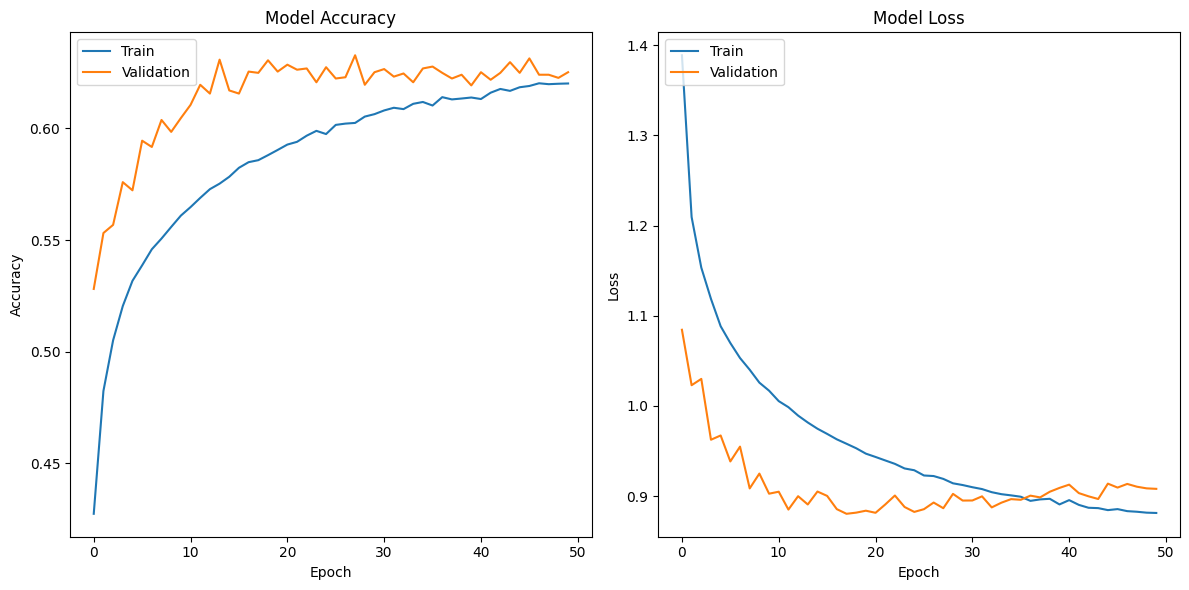

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
# Predict the test data
y_pred = model.predict(test_pixel_data.reshape(-1, image_height, image_width, num_channels))

# Convert one-hot encoded predictions and ground truth to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(to_categorical(y_test, num_classes=num_classes), axis=1)

# Generate the classification report
classification_report_result = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:\n", classification_report_result)

112/112 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       236
           1       0.70      0.62      0.66       226
           2       0.54      0.45      0.49       281
           3       0.57      0.60      0.58       819
           4       0.61      0.64      0.62      1147
           5       0.62      0.61      0.61       598
           6       0.71      0.63      0.67       249

    accuracy                           0.62      3556
   macro avg       0.66      0.64      0.65      3556
weighted avg       0.63      0.62      0.62      3556



In [30]:
# Assuming you have true ages as a single value per sample
# Convert them to one-hot encoded format
y_true_one_hot = to_categorical(y_test, num_classes=num_classes)

# Now calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true_one_hot, predicted_ages)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 0.13


112/112 [==============================] - 0s 1ms/step


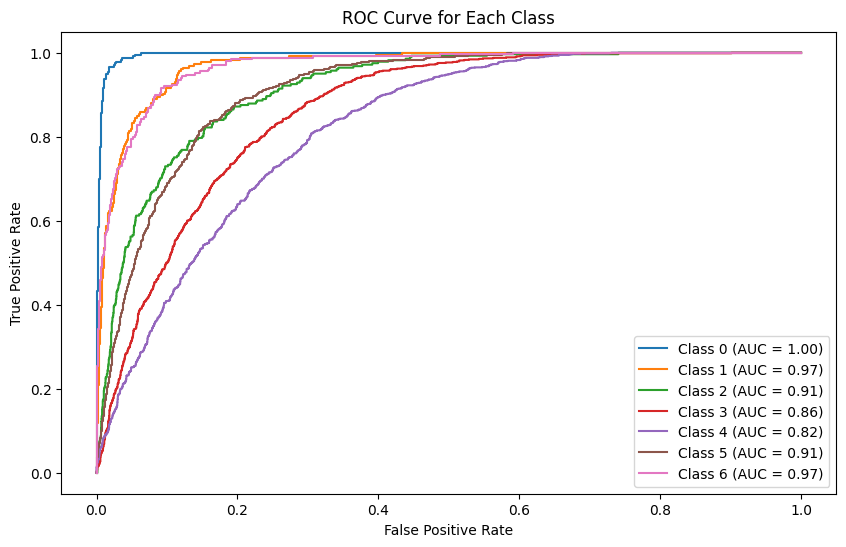

Confusion Matrix:
[[215  20   0   0   1   0   0]
 [ 31 139  40   3   8   3   2]
 [  0  34 126  90  28   3   0]
 [  1   2  42 489 269  16   0]
 [  0   1  21 269 733 121   2]
 [  0   1   3   8 162 363  61]
 [  0   1   0   0  10  81 157]]


In [29]:
# Get the predicted probabilities for each class
y_pred_prob = model.predict(test_pixel_data.reshape(-1, image_height, image_width, num_channels))

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_test, num_classes=num_classes)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.show()

# Create a confusion matrix
confusion_mat = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)

# APPROACH 3:

## Changing Age Classification Ranges

In [42]:
"""
Defining a function`map_age_to_class`
"""
def map_age_to_Newclass(age):
    if age >= 1 and age <= 12:                   # (Infants and Children)
        return 0
    elif age >= 13 and age <= 19:                # (Teenagers)
        return 1
    elif age >= 20 and age <= 35:                # (Young Adults)
        return 2
    elif age >= 36 and age <= 45:                # (Adults)
        return 3
    elif age >= 46 and age <= 60:                # (Middle-aged Adults)
        return 4
    elif age >= 61 and age <= 80:                # (Seniors)
        return 5
    else:
        return 6  #                              # (Elderly)

In [43]:
# train_df_augmented = pd.read_csv('train_df_augmented_v2.csv')
# val_df = pd.read_csv('val_df_v2.csv')
# test_df = pd.read_csv('test_df_v2.csv')

In [44]:
"""
Applying the map_age_to_class function
"""
train_df_augmented['target'] = train_df_augmented['age'].map(map_age_to_Newclass)
val_df['target'] = val_df['age'].map(map_age_to_Newclass)
test_df['target'] = test_df['age'].map(map_age_to_Newclass)

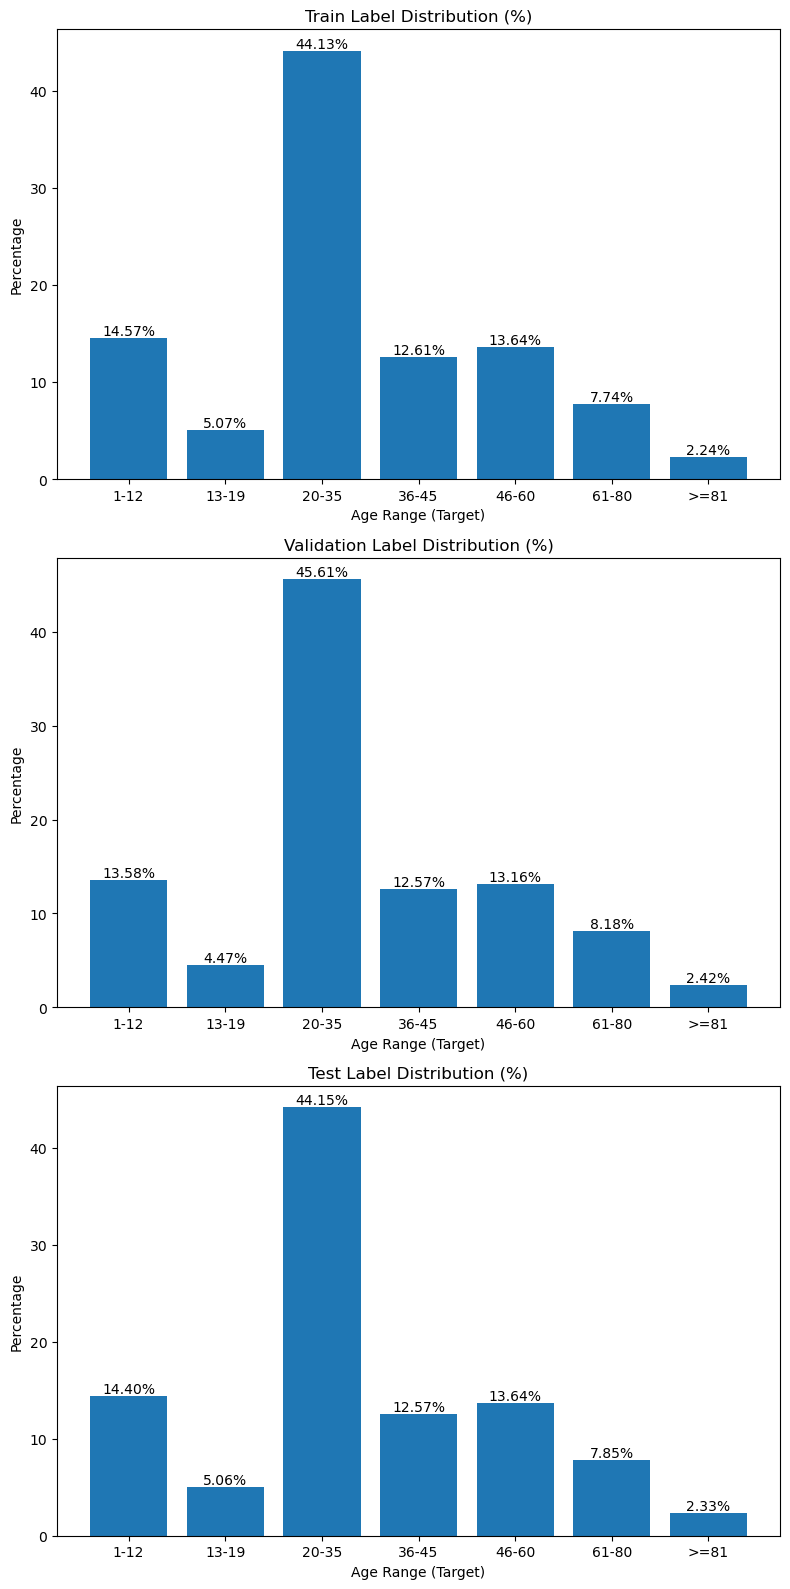

In [45]:
"""
Visualizing the distribution
"""
# Define the class ranges and labels
class_ranges = [
    "1-12",
    "13-19",
    "20-35",
    "36-45",
    "46-60",
    "61-80",
    ">=81"
]

# Get the label distribution for each set
train_label_distribution = train_df_augmented['target'].value_counts(normalize=True).sort_index() * 100
val_label_distribution = val_df['target'].value_counts(normalize=True).sort_index() * 100
test_label_distribution = test_df['target'].value_counts(normalize=True).sort_index() * 100


# Create bar plots
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Function to add percentage labels on top of bars
def add_percentage_labels(ax, distribution):
    for i, percentage in enumerate(distribution):
        ax.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

# Train set
train_bars = axes[0].bar(class_ranges, train_label_distribution)
axes[0].set_title("Train Label Distribution (%)")
axes[0].set_xlabel("Age Range (Target)")
axes[0].set_ylabel("Percentage")
add_percentage_labels(axes[0], train_label_distribution)

# Validation set
val_bars = axes[1].bar(class_ranges, val_label_distribution)
axes[1].set_title("Validation Label Distribution (%)")
axes[1].set_xlabel("Age Range (Target)")
axes[1].set_ylabel("Percentage")
add_percentage_labels(axes[1], val_label_distribution)

# Test set
test_bars = axes[2].bar(class_ranges, test_label_distribution)
axes[2].set_title("Test Label Distribution (%)")
axes[2].set_xlabel("Age Range (Target)")
axes[2].set_ylabel("Percentage")
add_percentage_labels(axes[2], test_label_distribution)

plt.tight_layout()
plt.show()

In [46]:
# Define the dimensions of your grayscale images (48x48)
image_height, image_width, num_channels = 48, 48, 1  # Set num_channels to 1 for grayscale

# Define the number of output classes (adjust as needed)
num_classes = 7

# Extract pixel data and labels from your dataframes
train_aug_pixel_data = np.array(train_df_augmented.iloc[:, 4:-1])
val_pixel_data = np.array(val_df.iloc[:, 4:-1])
test_pixel_data = np.array(test_df.iloc[:, 4:-1])

y_train = np.array(train_df_augmented['target'])
y_val = np.array(val_df['target'])
y_test = np.array(test_df['target'])

# Normalize the pixel data to the range [0, 1] (assuming they are in the range [0, 255])
train_aug_pixel_data = train_aug_pixel_data / 255.0
val_pixel_data = val_pixel_data / 255.0
test_pixel_data = test_pixel_data / 255.0

In [47]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a simple CNN model with modifications
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 23, 23, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                      

In [48]:
# Train the model with data augmentation
epochs = 50  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

history = model.fit(
    train_datagen.flow(train_aug_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                       to_categorical(y_train, num_classes=num_classes),
                       batch_size=batch_size),
    validation_data=(val_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                    to_categorical(y_val, num_classes=num_classes)),
    epochs=epochs,
    verbose=1
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_pixel_data.reshape(-1, image_height, image_width, num_channels), 
                                          to_categorical(y_test, num_classes=num_classes))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
5704/5704 [==============================] - 380s 66ms/step - loss: 1.2720 - accuracy: 0.5498 - val_loss: 0.9601 - val_accuracy: 0.6378
Epoch 2/50
5704/5704 [==============================] - 374s 66ms/step - loss: 1.0990 - accuracy: 0.5958 - val_loss: 0.9612 - val_accuracy: 0.6313
Epoch 3/50
5704/5704 [==============================] - 377s 66ms/step - loss: 1.0480 - accuracy: 0.6096 - val_loss: 0.9133 - val_accuracy: 0.6490
Epoch 4/50
5704/5704 [==============================] - 367s 64ms/step - loss: 1.0131 - accuracy: 0.6198 - val_loss: 0.8888 - val_accuracy: 0.6549
Epoch 5/50
5704/5704 [==============================] - 367s 64ms/step - loss: 0.9884 - accuracy: 0.6261 - val_loss: 0.8918 - val_accuracy: 0.6665
Epoch 6/50
5704/5704 [==============================] - 366s 64ms/step - loss: 0.9714 - accuracy: 0.6302 - val_loss: 0.8485 - val_accuracy: 0.6741
Epoch 7/50
5704/5704 [==============================] - 368s 65ms/step - loss: 0.9540 - accuracy: 0.6364 - val_loss: 0

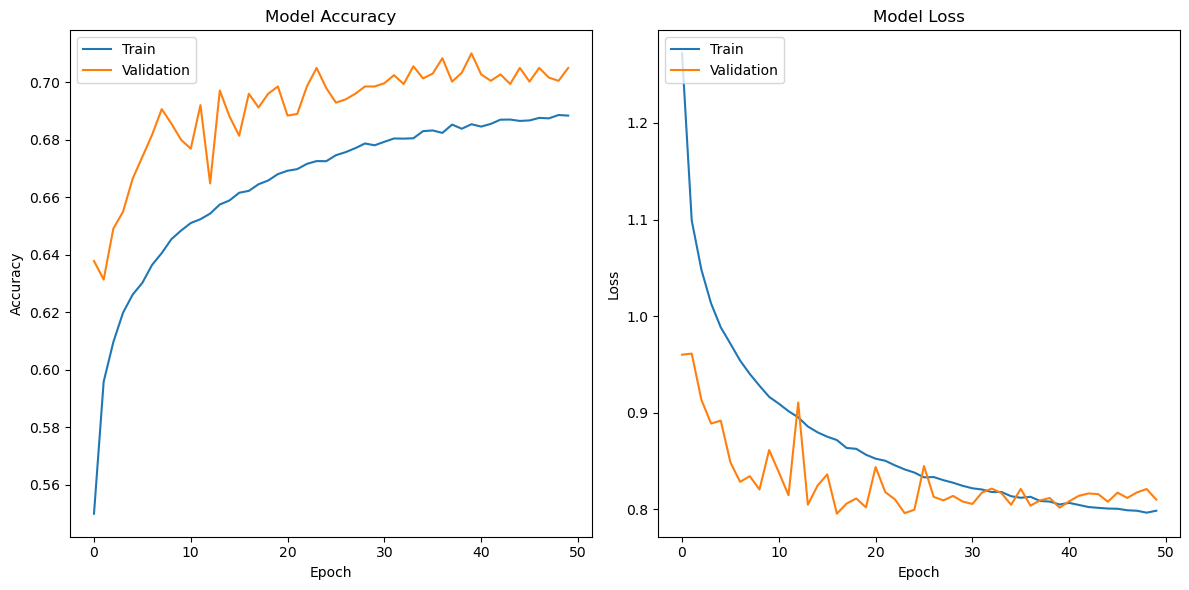

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [50]:
# Predict the test data
y_pred = model.predict(test_pixel_data.reshape(-1, image_height, image_width, num_channels))

# Convert one-hot encoded predictions and ground truth to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(to_categorical(y_test, num_classes=num_classes), axis=1)

# Generate the classification report
classification_report_result = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:\n", classification_report_result)

112/112 [==============================] - 2s 12ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       512
           1       0.41      0.26      0.32       180
           2       0.75      0.89      0.82      1570
           3       0.37      0.18      0.24       447
           4       0.50      0.51      0.51       485
           5       0.58      0.56      0.57       279
           6       0.65      0.53      0.58        83

    accuracy                           0.69      3556
   macro avg       0.59      0.55      0.56      3556
weighted avg       0.66      0.69      0.67      3556



112/112 [==============================] - 1s 12ms/step


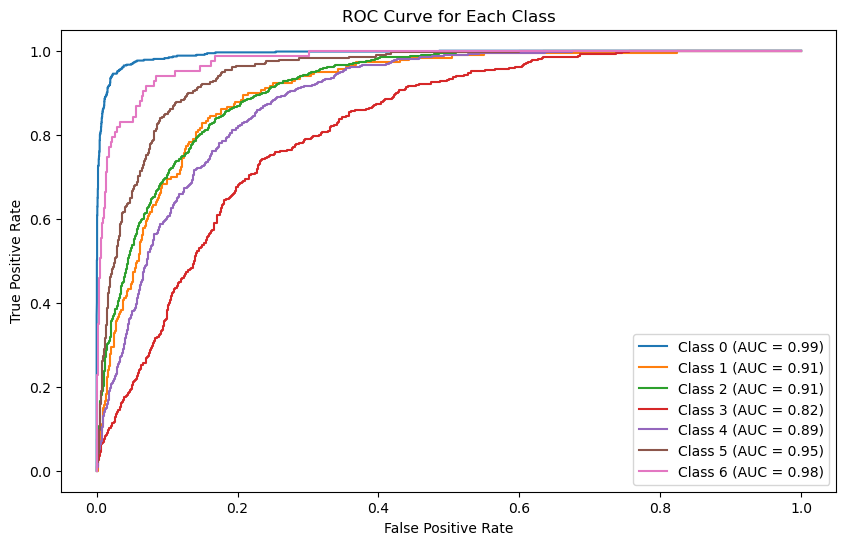

Confusion Matrix:
[[ 469   24   15    0    4    0    0]
 [  39   46   92    1    2    0    0]
 [   8   37 1401   76   45    3    0]
 [   2    1  245   82  108    9    0]
 [   2    3   96   60  249   73    2]
 [   4    0    8    5   83  157   22]
 [   1    0    1    0    7   30   44]]


In [51]:
# Get the predicted probabilities for each class
y_pred_prob = model.predict(test_pixel_data.reshape(-1, image_height, image_width, num_channels))

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_test, num_classes=num_classes)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.show()

# Create a confusion matrix
confusion_mat = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)